In [ ]:
import torch
import torch.nn as nn

class GaussianRBFNetworkC(nn.Module):
    def __init__(self, gaussian_regularizer, centers_regularizer, weights_regularizer, learnable_centers,
                 centers, device='cuda'):
        super(GaussianRBFNetworkC, self).__init__()

        self.device = device
        self.gaussian_regularizer = gaussian_regularizer
        self.centers_regularizer = centers_regularizer
        self.weights_regularizer = weights_regularizer
        self.centers = centers
        self.learnable_centers = learnable_centers
        self.n_centers = centers.shape[0]
        self.n_features = centers.shape[1]
        # Define learnable parameters
        self.precision_elements = nn.Parameter(torch.randn(self.n_features * (self.n_features + 1) // 2)
                                               .to(self.device))
        if self.learnable_centers == True:
            self.centers = nn.Parameter(centers.to(self.device))
        else:
            self.centers_regularizer = 1e-32
        self.weights = nn.Parameter(torch.randn(self.n_centers)
                                    .to(self.device))

    def compute_precision(self, precision_elements):

        lower_tri = torch.zeros((self.n_features, self.n_features)).to(self.device)
        idx = torch.tril_indices(*lower_tri.shape)
        lower_tri[idx[0], idx[1]] = precision_elements
        precision_matrix = torch.matmul(lower_tri, lower_tri.T)
        return precision_matrix

    def forward(self, X):

        precision_matrix = self.compute_precision(self.precision_elements)
        diff = X[:, None, :] - self.centers.unsqueeze(0)



        Phi = torch.exp(-0.5 * torch.einsum('ijk, kl, ijl -> ij', diff, precision_matrix, diff))

        #self.bn = nn.BatchNorm1d(Phi)  # Initialize BatchNorm1d layer
        #y_hat = torch.relu(torch.batch_norm(input= Phi , weights= self.weights,bias=None,running_mean=None,running_var=None,training=False,momentum=0.001,eps=0.0000001,cudnn_enabled=False))
        '''y_hat = torch.relu(torch.nn.functional.batch_norm(input=Phi, running_mean=torch.zeros(Phi.shape[1], device=self.device),
                                                         running_var=torch.ones(Phi.shape[1], device=self.device),
                                                          weight=self.weights,bias=None, training=False, momentum=0.1, eps=1e-05)) # shape (batch_size,)'''
        '''variance=X.var(dim=0)
        diff=diff/variance
        y_hat = torch.relu(torch.nn.functional.batch_norm(input=Phi, running_mean=diff,
                                                         running_var=variance[None,:],
                                                          weight=self.weights,bias=None, training=False, momentum=0.1, eps=1e-05)) # shape (batch_size,)'''

        y_hat = torch.sigmoid(Phi @ self.weights)
        return y_hat

    def evaluate_loss(self, y, y_hat):

        bce_loss = nn.BCELoss()
        loss = bce_loss(y_hat, y)
        reg_gaussian = self.gaussian_regularizer * torch.linalg.norm(self.precision_elements)
        reg_centers = self.centers_regularizer * torch.linalg.norm(self.centers)
        reg_weights = self.weights_regularizer * torch.linalg.norm(self.weights)
        loss = loss + reg_gaussian + reg_centers + reg_weights
        return loss

    def feature_importance(self, precision_matrix):

        eigenvalues, eigenvectors = torch.linalg.eigh(precision_matrix)
        feature_importance = torch.matmul(torch.abs(eigenvectors), eigenvalues)
        return feature_importance / torch.sum(feature_importance), eigenvalues, eigenvectors

In [ ]:
# Import necessary libraries
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
# Load the heart attack dataset
data = pd.read_csv('heart.csv')

# Preview the dataset
print(data.head())

# Assume the target variable is named 'output' (1 for heart attack, 0 for no heart attack)
# Adjust feature columns based on your dataset
X = data.drop(columns=['target'])#['output'])  # Features
y = data['target']#['output']  # Target variable

# Convert to numpy arrays
X = X.to_numpy() #values
y = y.to_numpy()#values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Standardize the data
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_st = torch.tensor(X_train_st, dtype=torch.float32)
X_test_st = torch.tensor(X_test_st, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Check the shapes of the tensors
print(X_train_st.shape, y_train.shape)
print(X_test_st.shape, y_test.shape)

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  
torch.Size([717, 13]) torch.Size([717])
torch.Size([308, 13]) torch.Size([308])


In [ ]:
import torch
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np

# Step 1: Define parameters
n_centers =16   # Number of RBF centers
gamma = 0.1    # Gamma for the RBF kernel
learnable_centers = True
gaussian_reg, centers_reg, weights_reg = 1e-2, None, 1e-5

# Step 2: Compute RBF affinity matrix
affinity_matrix = rbf_kernel(X_train_st, gamma=gamma)

# Step 3: Perform Spectral Clustering to get cluster labels
spectral_clustering = SpectralClustering(n_clusters=n_centers, affinity='rbf',gamma=gamma/10, assign_labels='kmeans')#,n_components=X_train_st.shape[1])
labels = spectral_clustering.fit_predict(affinity_matrix)

# Step 4: Calculate centers as the mean of points in each cluster
centers = []
for i in range(n_centers):
    cluster_points = X_train_st[labels == i]
    center = cluster_points.mean(axis=0)
    centers.append(center)

centers = torch.tensor(np.array(centers), dtype=torch.float32)

# 'centers' now contains the RBF centers determined via Spectral Clustering


In [ ]:
# Define regularization parameters
gaussian_reg = 0.01  # Example regularization weight for Gaussian width
centers_reg = 0.01   # Example regularization weight for centers
weights_reg = 0.01   # Example regularization weight for weights
learnable_centers = False  # Set to True if the centers are trainable
#centers = torch.rand(10, X_train_st.shape[1])  # Example initialization with 10 centers
# Calculate the centers (mean of points in each cluster based on labels)
centers = np.array([X_train_st[labels == i].mean(axis=0) for i in range(n_centers)])
centers = torch.tensor(centers, dtype=torch.float32)
print(centers.shape)

torch.Size([16, 13])


In [ ]:
for i in range(n_centers):
    points_in_cluster = X_train_st[labels == i]  # Points assigned to this cluster
    print(f"Center {i} (label {i}) has {len(points_in_cluster)} points:")
    print(points_in_cluster)
    print(f"Cluster Center {i}: {centers[i]}\n")


Center 0 (label 0) has 44 points:
tensor([[ 0.9426,  0.6523, -0.9173, -0.0966,  0.1784, -0.4211, -0.9637, -0.0963,
         -0.7005,  0.3074, -0.6611,  0.2329,  1.1032],
        [ 0.2772,  0.6523,  1.0256, -0.2102, -0.3143, -0.4211, -0.9637,  0.0337,
         -0.7005, -0.5743, -0.6611,  0.2329,  1.1032],
        [-0.0555,  0.6523,  1.0256, -0.6644,  0.2572, -0.4211, -0.9637, -0.0963,
         -0.7005, -0.5743, -0.6611, -0.7379,  1.1032],
        [-0.0555,  0.6523,  1.0256, -0.3805,  0.5529, -0.4211, -0.9637,  0.1204,
         -0.7005, -0.4861, -2.3013,  0.2329, -0.5111],
        [ 1.2753,  0.6523, -0.9173, -0.6644,  1.1245, -0.4211, -0.9637,  0.0771,
         -0.7005, -0.5743, -0.6611, -0.7379, -0.5111],
        [-0.4991,  0.6523, -0.9173,  1.0390, -0.0384, -0.4211, -0.9637, -0.9199,
         -0.7005,  1.3655, -0.6611, -0.7379,  1.1032],
        [ 0.8317,  0.6523,  0.0542, -0.6644,  0.7106, -0.4211, -0.9637, -2.0035,
         -0.7005,  0.3074, -0.6611,  0.2329,  1.1032],
        [ 0.38

In [ ]:
# Assuming `centers` is your tensor of cluster centers and `labels` is the array of labels
for i in range(n_centers):
    print(f"Center {i} (label {i}): {centers[i]}")


Center 0 (label 0): tensor([ 0.3982,  0.6523, -0.0341, -0.1831,  0.3925, -0.4211, -0.8350,  0.0515,
        -0.7005,  0.1451, -0.6238,  0.1005,  0.7730])
Center 1 (label 1): tensor([ 0.0254, -0.1803,  0.2701,  0.7524,  0.0013,  0.4664,  0.1151, -0.0048,
         0.0089,  1.0772, -0.8954, -0.1678, -0.7417])
Center 2 (label 2): tensor([ 0.5113,  0.5309,  0.7558,  1.1841, -0.3477, -0.4211, -0.7015,  0.0097,
        -0.3458, -0.3000,  0.3412, -0.6031,  0.4754])
Center 3 (label 3): tensor([ 0.6081, -0.4925, -0.7785,  0.9579,  0.9765,  0.5552, -0.5142, -0.4107,
         0.8196,  0.4264, -0.7392,  0.8955,  0.4626])
Center 4 (label 4): tensor([ 0.2032, -1.3712,  0.5219,  0.0264,  1.0033, -0.4211,  0.0502,  0.4487,
        -0.7005, -0.5971,  0.9791, -0.5222, -0.4812])
Center 5 (label 5): tensor([ 0.5752,  0.6523, -0.9173, -0.0824, -0.2977, -0.4211, -0.9637, -0.8183,
         1.4276,  1.5556, -0.3536,  0.9003,  0.6996])
Center 6 (label 6): tensor([-0.7788,  0.6048, -0.1570, -0.5780, -0.3717, -0.

In [ ]:

batch_size = 256
step_size = 0.01  #learning rate
model = GaussianRBFNetworkC(gaussian_regularizer=gaussian_reg, centers_regularizer=centers_reg,
                            weights_regularizer=weights_reg, learnable_centers=learnable_centers, centers=centers,
                            device='cpu')

# Create data loaders
train_dataset = TensorDataset(X_train_st, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Training settings
optimizer = optim.Adam(model.parameters(), lr=step_size)

##replace  with GCADAM
n_epochs = 5000

# Training loop
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_hat = model(batch_X)
        loss = model.evaluate_loss(batch_y, y_hat)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {epoch_loss / len(train_loader)}')

Epoch 0, Loss: 0.8422625263532003
Epoch 50, Loss: 0.4669003486633301
Epoch 100, Loss: 0.36761446793874103
Epoch 150, Loss: 0.3654049535592397
Epoch 200, Loss: 0.3605789542198181
Epoch 250, Loss: 0.36525635917981464
Epoch 300, Loss: 0.36176377534866333
Epoch 350, Loss: 0.36365076899528503
Epoch 400, Loss: 0.35977645715077716
Epoch 450, Loss: 0.36082247893015545
Epoch 500, Loss: 0.35786489645640057
Epoch 550, Loss: 0.3589263657728831
Epoch 600, Loss: 0.36270707845687866
Epoch 650, Loss: 0.3595522443453471
Epoch 700, Loss: 0.36024950941403705
Epoch 750, Loss: 0.3617108166217804
Epoch 800, Loss: 0.3615830639998118
Epoch 850, Loss: 0.3589923679828644
Epoch 900, Loss: 0.3589321970939636
Epoch 950, Loss: 0.356189101934433
Epoch 1000, Loss: 0.3617668151855469
Epoch 1050, Loss: 0.35701051354408264
Epoch 1100, Loss: 0.3585607906182607
Epoch 1150, Loss: 0.3600834707419078
Epoch 1200, Loss: 0.36134447654088336
Epoch 1250, Loss: 0.35913116733233136
Epoch 1300, Loss: 0.3616130252679189
Epoch 1350, L

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_st).numpy() > 0.5
    y_test_pred = model(X_test_st).numpy() > 0.5

# Convert y_train and y_test to NumPy arrays before using accuracy_score
train_accuracy = accuracy_score(y_train.numpy(), y_train_pred) # Changed line
test_accuracy = accuracy_score(y_test.numpy(), y_test_pred)   # Changed line

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Train Accuracy: 0.8758716875871687
Test Accuracy: 0.8831168831168831


In [ ]:
# Evaluate the model
#model.eval()
#with torch.no_grad():
    #y_train_pred = np.round(model(X_train_st).numpy(),1)>=0.5 #0.4#0.5
    #y_test_pred = np.round (model(X_test_st).numpy(),1) >=0.5#0.4# 0.5
    #y_train_pred = model(X_train_st).numpy()>0.5 #0.4#0.5
    #y_test_pred = model(X_test_st).numpy() >0.5#0.4# 0.5

#train_accuracy = accuracy_score(y_train, y_train_pred)
#test_accuracy = accuracy_score(y_test, y_test_pred)

#print(f'Train Accuracy: {train_accuracy}')
#print(f'Test Accuracy: {test_accuracy}')

In [ ]:
# Extract feature importance
precision_matrix = model.compute_precision(model.precision_elements)
feature_importance1, eigenvalues, eigenvectors = model.feature_importance(precision_matrix)

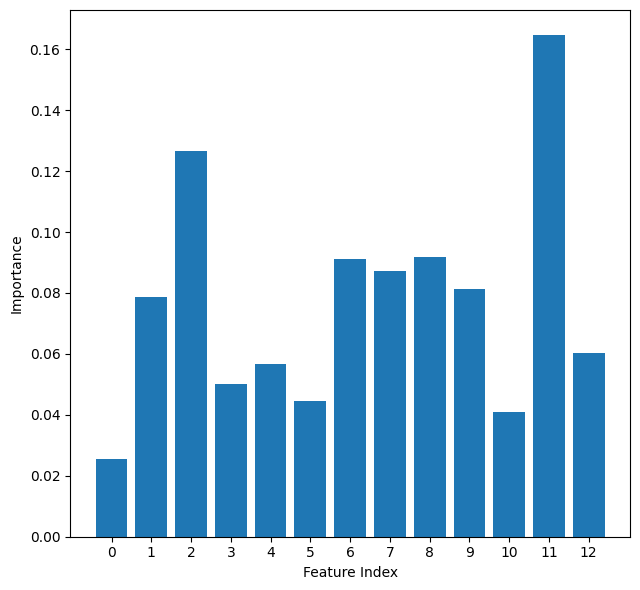

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

# Example feature_importance (assuming it is a torch tensor from your model)
# You need to replace this with actual feature importance from your model
#feature_importance = torch.rand(13)  # Assuming 13 features in the heart dataset

# Detach if required and convert to numpy array
feature_importance = feature_importance1.detach().numpy()

# Assuming X is the feature matrix and y is the target
# Replace X and y with actual data from your heart dataset
# For example, X_train, y_train from the split step
mean_no_disease = X[y == 0].mean(axis=0)  # Mean of class '0' (no heart disease)
mean_disease = X[y == 1].mean(axis=0)     # Mean of class '1' (heart disease)

# Plot the feature importance and class means
plt.figure(figsize=(18, 6))

# Plot 1: Feature Importance as a bar plot
plt.subplot(1, 3, 1)
#plt.title("Feature Importance")
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.xticks(np.arange(len(feature_importance)))

'''# Plot 2: Mean of Class '0' (No Heart Disease) as a heatmap
plt.subplot(1, 3, 2)
plt.title("Mean of Class '0' (covid negative)")
sns.heatmap(mean_no_disease.reshape(1, -1), cmap='coolwarm', annot=True, cbar=True, xticklabels=data.columns[:-1])
plt.yticks([])

# Plot 3: Mean of Class '1' (Heart Disease) as a heatmap
plt.subplot(1, 3, 3)
plt.title("Mean of Class '1' (covid positive)")
sns.heatmap(mean_disease.reshape(1, -1), cmap='coolwarm', annot=True, cbar=True, xticklabels=data.columns[:-1])
plt.yticks([])'''

# Show the plots
plt.tight_layout()
plt.show()


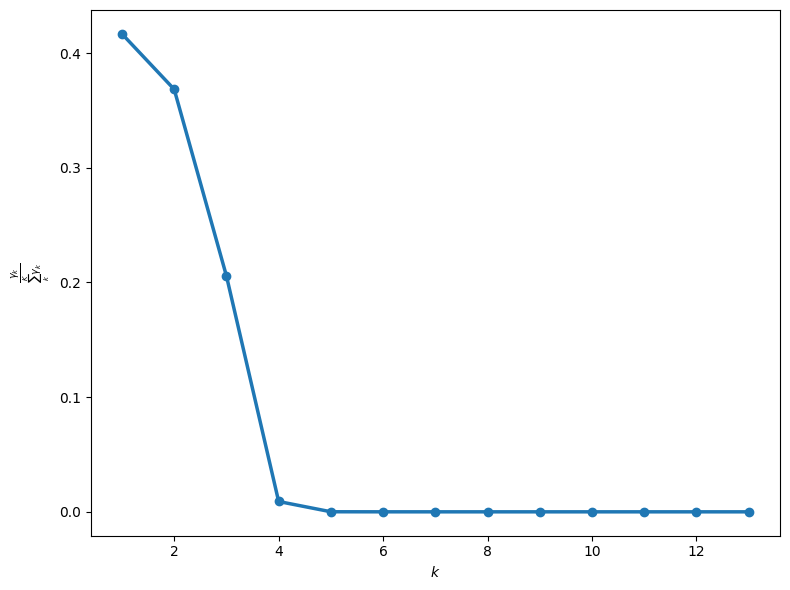

In [ ]:
# Plot eigenvalues decay
gammas = eigenvalues.detach().numpy()[::-1] # sort eigenvalues
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(gammas) + 1), gammas / np.sum(gammas), marker='o', linestyle='-', linewidth=2.5)
plt.xlabel('$k$')
#plt.title("Eigenvalues Decay")
plt.ylabel(r'$\frac{\gamma_k}{\sum_k^K \gamma_k}$')
plt.tight_layout()
plt.show()

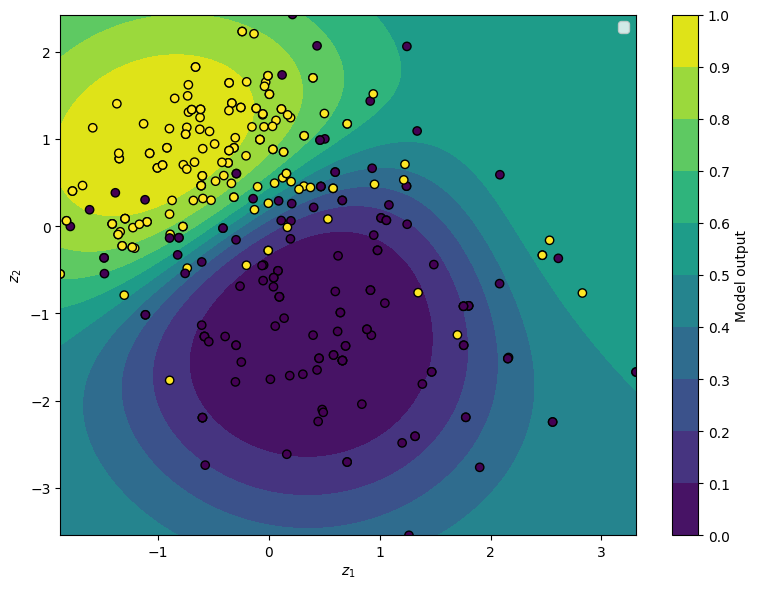

In [ ]:
# Plot contours

V = eigenvectors.detach().numpy()[:, ::-1] # sort eigenvectors
Z = np.dot(X_test_st, V[:, :2]) # project data into the latent or active subspace defined by the top-2 eigenvectors

lb1, ub1 = min(Z[:, 0]), max(Z[:, 0])
lb2, ub2 = min(Z[:, 1]), max(Z[:, 1])
xx1 = np.linspace(lb1, ub1, 100)
xx2 = np.linspace(lb2, ub2, 100)

XX1, XX2 = np.meshgrid(xx1, xx2)
xx12 = np.vstack([XX1.ravel(), XX2.ravel()]).T
xx12_back = np.dot(xx12, V[:, :2].T) # reproject back data from the active subspace so that we can evaluate the model
xx12_back = torch.tensor(xx12_back, dtype=torch.float32)

#XX3 = (np.round(model(xx12_back).detach().numpy(),1)).reshape(XX1.shape) # obtan the model output
XX3 = model(xx12_back).detach().numpy().reshape(XX1.shape) # obtan the model output

fig, ax = plt.subplots(figsize=(8, 6))
# Plot centers
centers_projected = np.dot(model.centers.detach().numpy(), V[:, :2])

contours = plt.contourf(XX1, XX2, XX3, cmap='viridis', levels=np.linspace(0, 1, 11))
cbar = plt.colorbar(contours)
cbar.set_label('Model output')
cbar.set_ticks(np.linspace(0, 1, 11))

plt.scatter(Z[:, 0], Z[:, 1], c=y_test, edgecolors='black')
#plt.scatter(centers_projected[:, 0], centers_projected[:, 1], c='red', marker='x', label='Centers')

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
#plt.title('Active Subspace in 2D')
plt.legend()
plt.tight_layout()